# Wine Quality Prediction: Model Building and Evaluation

## 1. Introduction

In this notebook, we'll build and evaluate various supervised machine learning models to predict wine quality based on physicochemical properties. We'll use the processed data from our exploratory data analysis to train different classifiers, compare their performance, and optimize the best model.

### 1.1 Import Libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve,
                            ConfusionMatrixDisplay)

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')



## 2. Load Processed Data

First, let's load the processed data that we prepared in the EDA notebook.


In [5]:
with open('../data/processed/processed_data.pickle', 'rb') as f:
    processed_data = pickle.load(f)
    
X_train = processed_data['X_train']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_test = processed_data['y_test']

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Positive class (good quality) proportion in training set: {y_train.mean():.2f}")
print(f"Positive class (good quality) proportion in testing set: {y_test.mean():.2f}")

Training set shape: (1279, 11)
Testing set shape: (320, 11)
Positive class (good quality) proportion in training set: 0.14
Positive class (good quality) proportion in testing set: 0.13


## 3. Define Helper Functions

Let's define some helper functions to assist with model evaluation and visualization.

In [8]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance with various metrics."""
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate AUC if possible
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Return results
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'training_time': training_time,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix."""
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=['Bad Quality', 'Good Quality'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/confusion_matrix_{model_name.replace(" ", "_").lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curve(y_test, y_scores, model_name):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/roc_curve_{model_name.replace(" ", "_").lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return auc

def feature_importance(model, features, model_name):
    """Plot feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(features.shape[1]), importances[indices])
        plt.xticks(range(features.shape[1]), [features.columns[i] for i in indices], rotation=90)
        plt.title(f'Feature Importance for {model_name}')
        plt.tight_layout()
        plt.savefig(f'../reports/figures/feature_importance_{model_name.replace(" ", "_").lower()}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print feature importance in descending order
        print(f"Feature Importance for {model_name}:")
        for i in indices:
            print(f"{features.columns[i]}: {importances[i]:.4f}")

## 4. Basic Model Comparison

Now, let's train and evaluate several classification algorithms to determine which performs best for our wine quality prediction task.

In [9]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}


===== Evaluating Logistic Regression =====
Accuracy: 0.8938
Precision: 0.6957
Recall: 0.3721
F1 Score: 0.4848
AUC: 0.8804
Training Time: 0.0152 seconds


<Figure size 800x600 with 0 Axes>

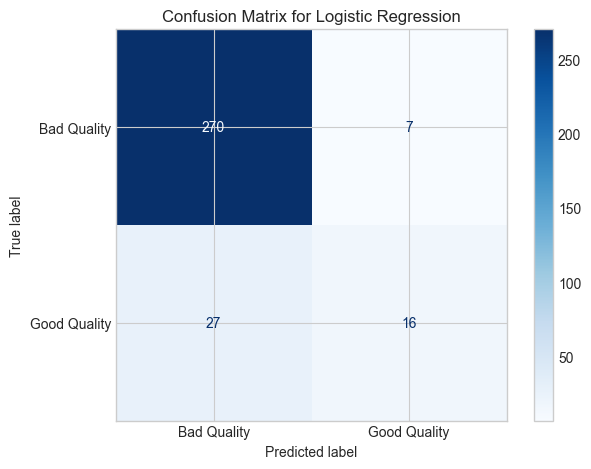

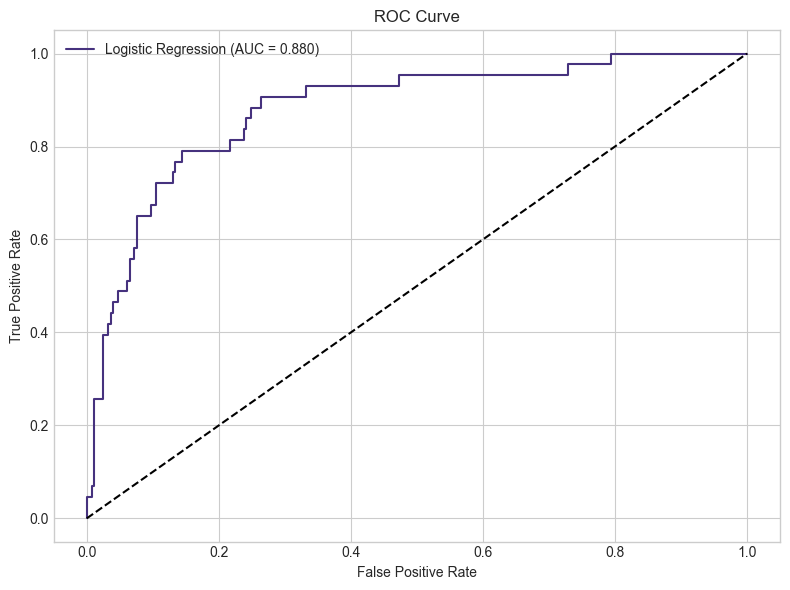


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       277
           1       0.70      0.37      0.48        43

    accuracy                           0.89       320
   macro avg       0.80      0.67      0.71       320
weighted avg       0.88      0.89      0.88       320


===== Evaluating Decision Tree =====
Accuracy: 0.9062
Precision: 0.6383
Recall: 0.6977
F1 Score: 0.6667
AUC: 0.8182
Training Time: 0.0050 seconds


<Figure size 800x600 with 0 Axes>

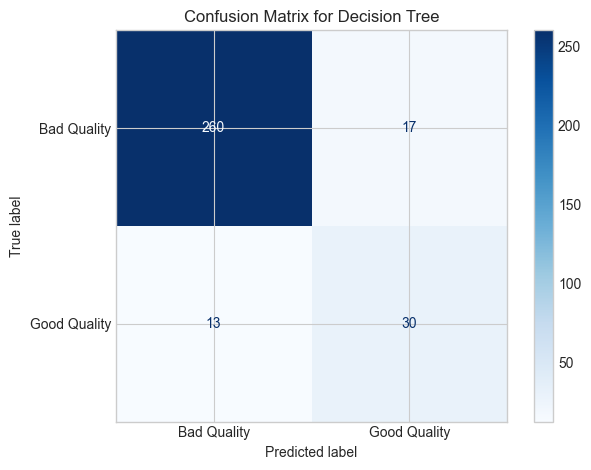

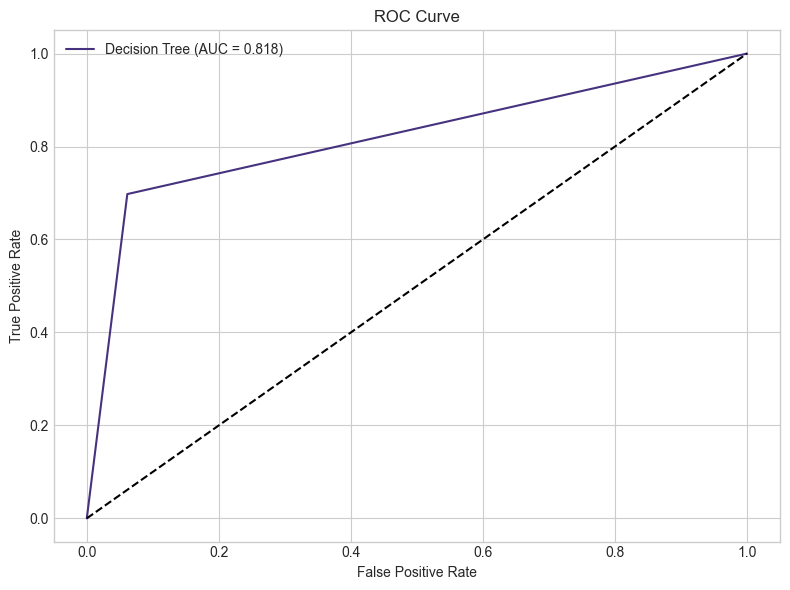


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       277
           1       0.64      0.70      0.67        43

    accuracy                           0.91       320
   macro avg       0.80      0.82      0.81       320
weighted avg       0.91      0.91      0.91       320



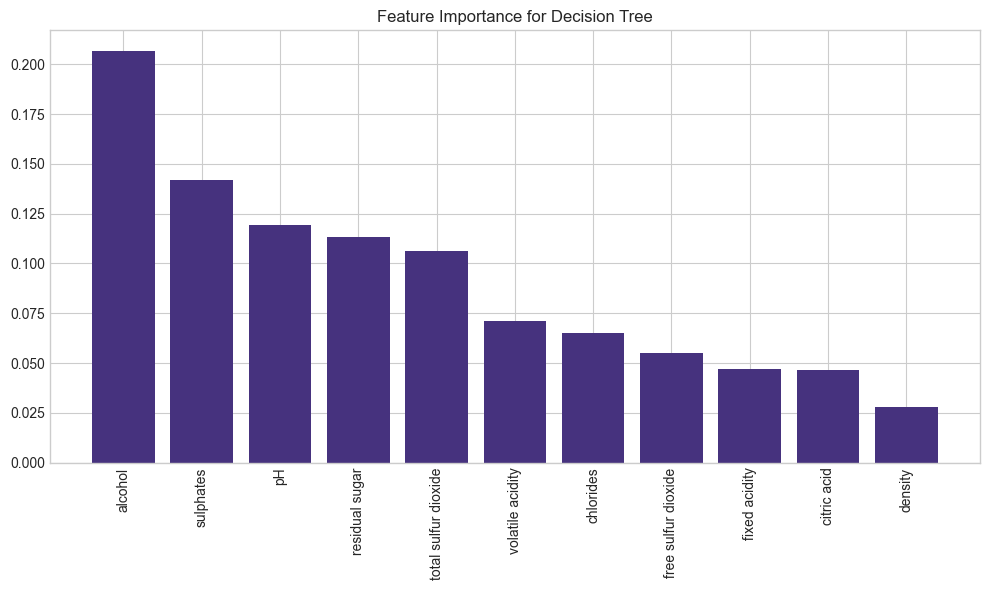

Feature Importance for Decision Tree:
alcohol: 0.2067
sulphates: 0.1417
pH: 0.1191
residual sugar: 0.1132
total sulfur dioxide: 0.1065
volatile acidity: 0.0713
chlorides: 0.0650
free sulfur dioxide: 0.0549
fixed acidity: 0.0471
citric acid: 0.0467
density: 0.0279

===== Evaluating Random Forest =====
Accuracy: 0.9375
Precision: 0.9259
Recall: 0.5814
F1 Score: 0.7143
AUC: 0.9546
Training Time: 0.1305 seconds


<Figure size 800x600 with 0 Axes>

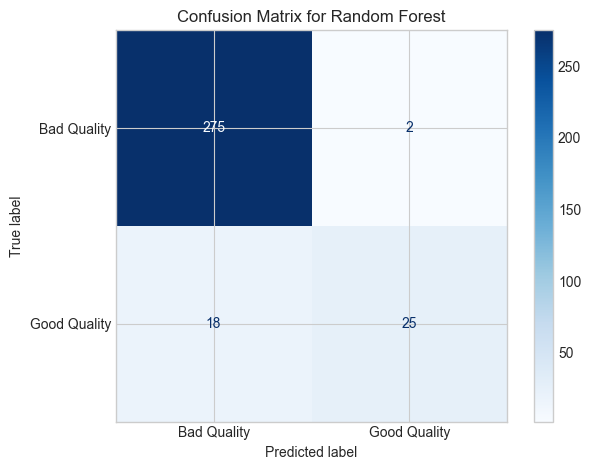

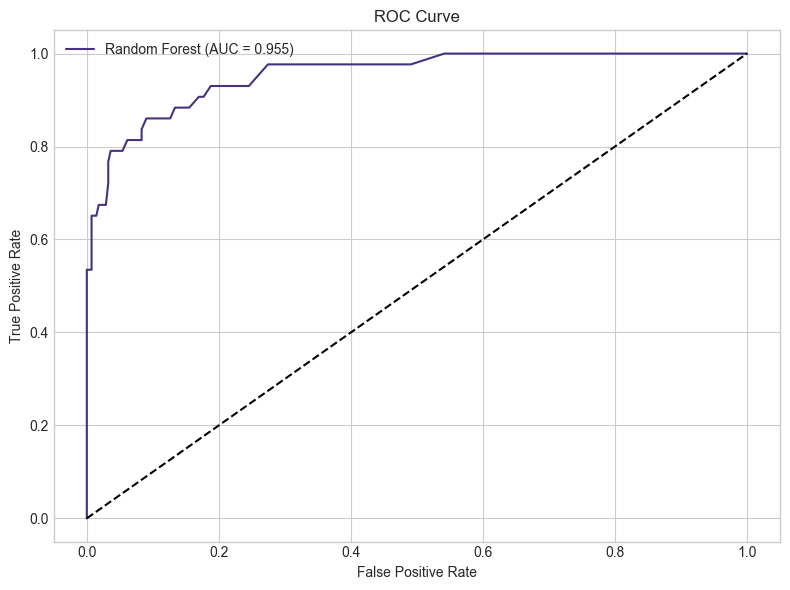


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.93      0.58      0.71        43

    accuracy                           0.94       320
   macro avg       0.93      0.79      0.84       320
weighted avg       0.94      0.94      0.93       320



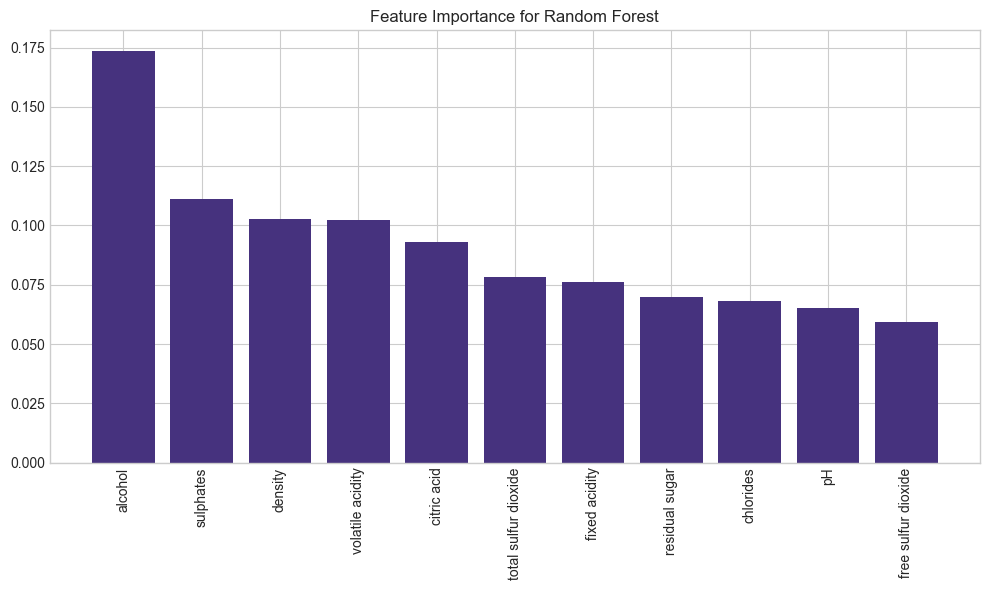

Feature Importance for Random Forest:
alcohol: 0.1736
sulphates: 0.1113
density: 0.1029
volatile acidity: 0.1024
citric acid: 0.0931
total sulfur dioxide: 0.0782
fixed acidity: 0.0763
residual sugar: 0.0697
chlorides: 0.0681
pH: 0.0653
free sulfur dioxide: 0.0591

===== Evaluating SVM =====
Accuracy: 0.9000
Precision: 0.7619
Recall: 0.3721
F1 Score: 0.5000
AUC: 0.8892
Training Time: 0.0567 seconds


<Figure size 800x600 with 0 Axes>

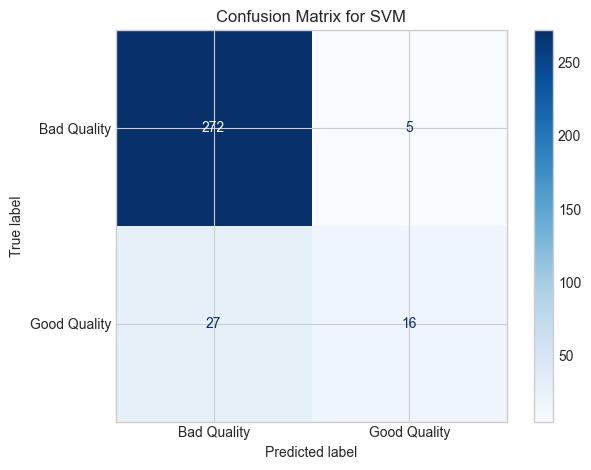

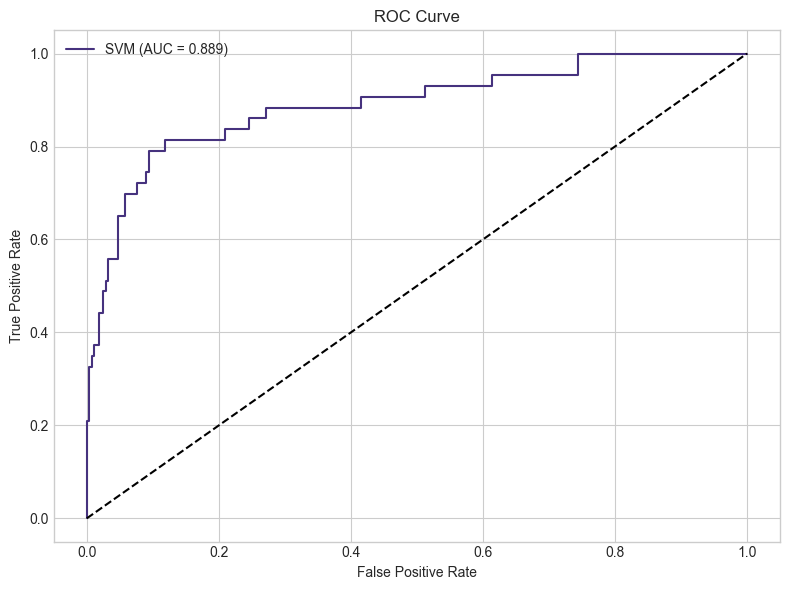


Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       277
           1       0.76      0.37      0.50        43

    accuracy                           0.90       320
   macro avg       0.84      0.68      0.72       320
weighted avg       0.89      0.90      0.88       320


===== Evaluating KNN =====
Accuracy: 0.8938
Precision: 0.6667
Recall: 0.4186
F1 Score: 0.5143
AUC: 0.8237
Training Time: 0.0013 seconds


<Figure size 800x600 with 0 Axes>

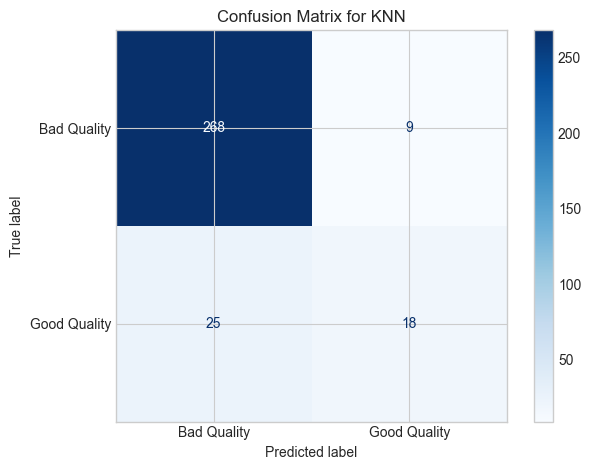

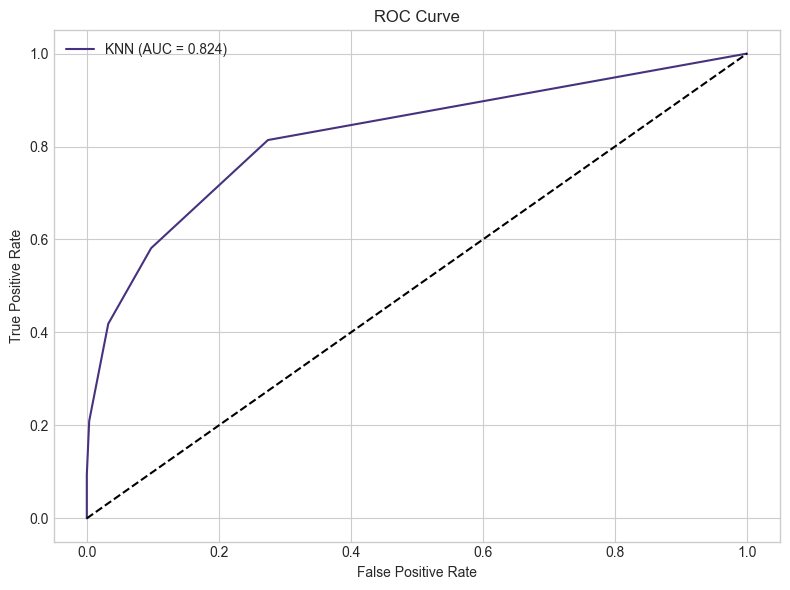


Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       277
           1       0.67      0.42      0.51        43

    accuracy                           0.89       320
   macro avg       0.79      0.69      0.73       320
weighted avg       0.88      0.89      0.88       320



In [10]:
# Evaluate each model
results = {}
for name, model in models.items():
    print(f"\n===== Evaluating {name} =====")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    # Print key metrics
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1 Score: {results[name]['f1_score']:.4f}")
    if results[name]['auc'] is not None:
        print(f"AUC: {results[name]['auc']:.4f}")
    print(f"Training Time: {results[name]['training_time']:.4f} seconds")
    
    # Plot confusion matrix
    plot_confusion_matrix(results[name]['confusion_matrix'], name)
    
    # Plot ROC curve if applicable
    if results[name]['y_pred_proba'] is not None:
        plot_roc_curve(y_test, results[name]['y_pred_proba'], name)
    
    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, results[name]['y_pred']))
    
    # Plot feature importance for tree-based models
    if name in ['Decision Tree', 'Random Forest']:
        feature_importance(results[name]['model'], X_train, name)

In [11]:
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1_score'] for m in results],
    'AUC': [results[m]['auc'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results]
})

print("\nModel Comparison:")
print(model_comparison.sort_values('F1 Score', ascending=False))


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
2        Random Forest   0.93750   0.925926  0.581395  0.714286  0.954622   
1        Decision Tree   0.90625   0.638298  0.697674  0.666667  0.818151   
4                  KNN   0.89375   0.666667  0.418605  0.514286  0.823650   
3                  SVM   0.90000   0.761905  0.372093  0.500000  0.889178   
0  Logistic Regression   0.89375   0.695652  0.372093  0.484848  0.880363   

   Training Time (s)  
2           0.130522  
1           0.005048  
4           0.001253  
3           0.056748  
0           0.015158  


<Figure size 1200x600 with 0 Axes>

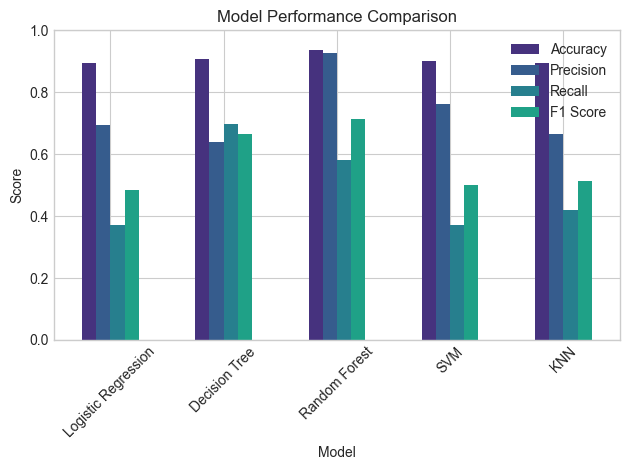

In [12]:
plt.figure(figsize=(12, 6))
model_comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Hyperparameter Tuning for Best Model

Now that we have a baseline performance for each model, let's perform hyperparameter tuning on the best-performing model to improve its performance further.


In [13]:
# Identify the best model based on F1 score
best_model_name = model_comparison.sort_values('F1 Score', ascending=False).iloc[0]['Model']
print(f"\nBest model based on F1 score: {best_model_name}")

# Define hyperparameter grid for the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2']
    }
    model = LogisticRegression(random_state=42)
elif best_model_name == 'Decision Tree':
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = DecisionTreeClassifier(random_state=42)
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    model = RandomForestClassifier(random_state=42)
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1],
        'kernel': ['rbf', 'linear']
    }
    model = SVC(probability=True, random_state=42)
else:  # KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # Manhattan or Euclidean distance
    }
    model = KNeighborsClassifier()


Best model based on F1 score: Random Forest


In [14]:
# Perform grid search with cross-validation
print("\nPerforming grid search for hyperparameter tuning...")
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")


Performing grid search for hyperparameter tuning...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation F1 score: 0.5275



Tuned Model Performance:
Accuracy: 0.9375
Precision: 0.8966
Recall: 0.6047
F1 Score: 0.7222
AUC: 0.9589


<Figure size 800x600 with 0 Axes>

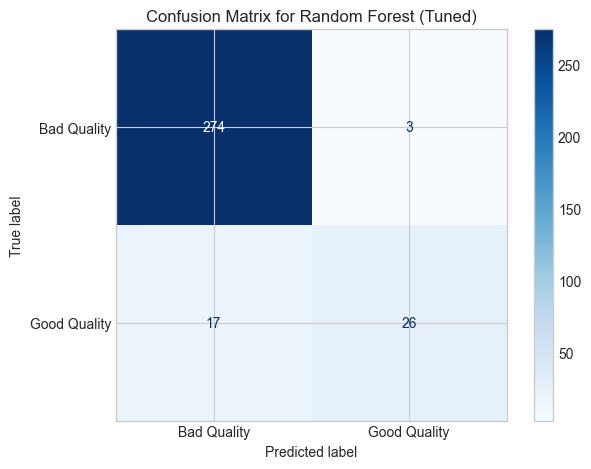

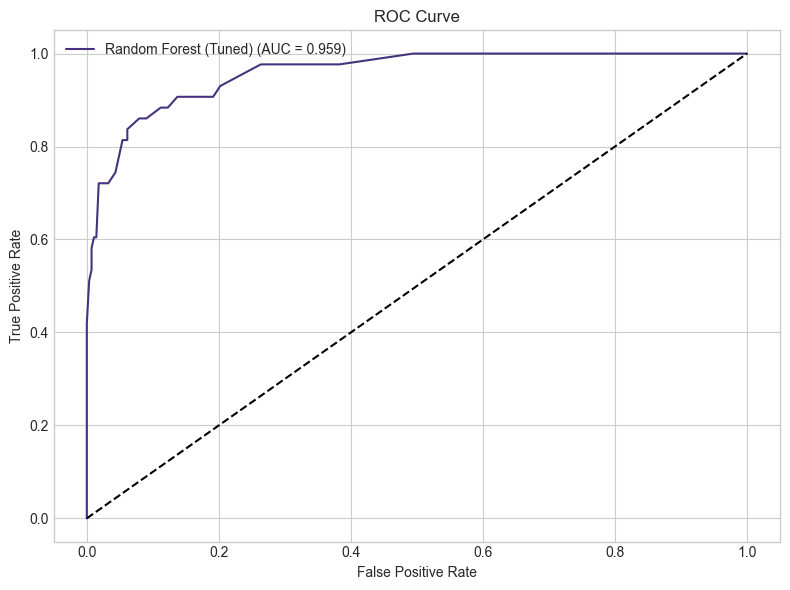


Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.90      0.60      0.72        43

    accuracy                           0.94       320
   macro avg       0.92      0.80      0.84       320
weighted avg       0.94      0.94      0.93       320



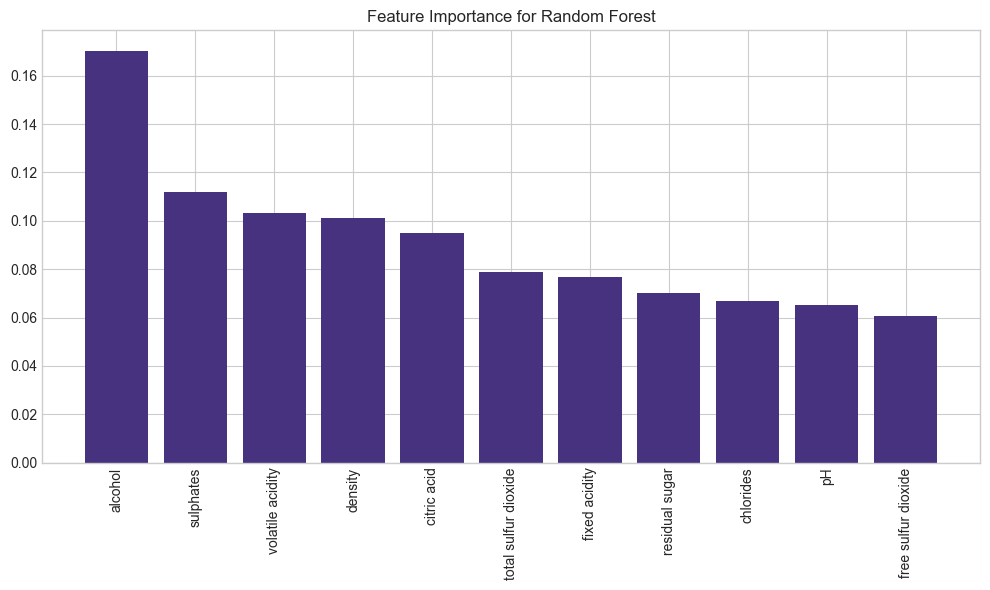

Feature Importance for Random Forest:
alcohol: 0.1702
sulphates: 0.1118
volatile acidity: 0.1031
density: 0.1011
citric acid: 0.0950
total sulfur dioxide: 0.0788
fixed acidity: 0.0769
residual sugar: 0.0703
chlorides: 0.0667
pH: 0.0653
free sulfur dioxide: 0.0608


In [17]:
# Get the tuned model
tuned_model = grid_search.best_estimator_

# Evaluate the tuned model
tuned_results = evaluate_model(tuned_model, X_train, X_test, y_train, y_test)

print("\nTuned Model Performance:")
print(f"Accuracy: {tuned_results['accuracy']:.4f}")
print(f"Precision: {tuned_results['precision']:.4f}")
print(f"Recall: {tuned_results['recall']:.4f}")
print(f"F1 Score: {tuned_results['f1_score']:.4f}")
if tuned_results['auc'] is not None:
    print(f"AUC: {tuned_results['auc']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(tuned_results['confusion_matrix'], f"{best_model_name} (Tuned)")

# Plot ROC curve if applicable
if tuned_results['y_pred_proba'] is not None:
    plot_roc_curve(y_test, tuned_results['y_pred_proba'], f"{best_model_name} (Tuned)")

# Print classification report
print(f"\nClassification Report for {best_model_name} (Tuned):")
print(classification_report(y_test, tuned_results['y_pred']))

# Plot feature importance for tree-based models
if best_model_name in ['Decision Tree', 'Random Forest']:
    feature_importance(tuned_results['model'], X_train, f"{best_model_name}")

In [18]:
# Compare original vs. tuned model performance
performance_improvement = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Original': [results[best_model_name]['accuracy'], 
                 results[best_model_name]['precision'],
                 results[best_model_name]['recall'],
                 results[best_model_name]['f1_score'],
                 results[best_model_name]['auc']],
    'Tuned': [tuned_results['accuracy'], 
              tuned_results['precision'],
              tuned_results['recall'],
              tuned_results['f1_score'],
              tuned_results['auc']],
    'Improvement': [tuned_results['accuracy'] - results[best_model_name]['accuracy'],
                   tuned_results['precision'] - results[best_model_name]['precision'],
                   tuned_results['recall'] - results[best_model_name]['recall'],
                   tuned_results['f1_score'] - results[best_model_name]['f1_score'],
                   tuned_results['auc'] - results[best_model_name]['auc']]
})

print("\nPerformance Improvement After Tuning:")
print(performance_improvement)


Performance Improvement After Tuning:
      Metric  Original     Tuned  Improvement
0   Accuracy  0.937500  0.937500     0.000000
1  Precision  0.925926  0.896552    -0.029374
2     Recall  0.581395  0.604651     0.023256
3   F1 Score  0.714286  0.722222     0.007937
4        AUC  0.954622  0.958946     0.004324


<Figure size 1000x600 with 0 Axes>

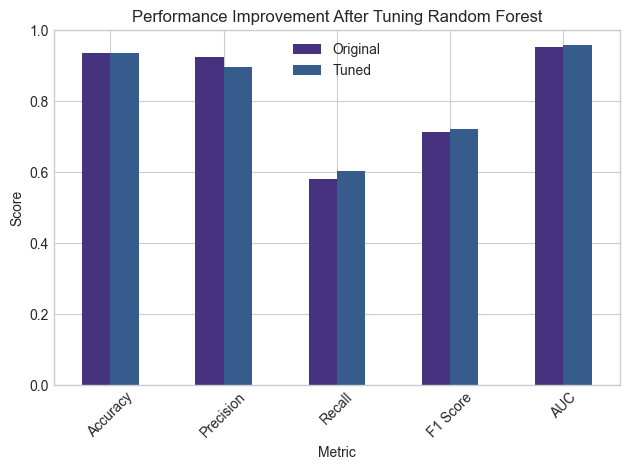

In [19]:
# Visualize performance improvement
plt.figure(figsize=(10, 6))
performance_improvement.set_index('Metric')[['Original', 'Tuned']].plot(kind='bar')
plt.title(f'Performance Improvement After Tuning {best_model_name}')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../reports/figures/performance_improvement_{best_model_name.replace(" ", "_").lower()}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Save the best model
with open(f'../models/{best_model_name.replace(" ", "_").lower()}_tuned.pickle', 'wb') as f:
    pickle.dump(tuned_model, f)
print(f"\nBest model saved to ../models/{best_model_name.replace(' ', '_').lower()}_tuned.pickle")


Best model saved to ../models/random_forest_tuned.pickle


## 6. Model Interpretation and Feature Analysis

Let's use permutation feature importance to understand which features are most important for our model's predictions.


Calculating permutation feature importance...


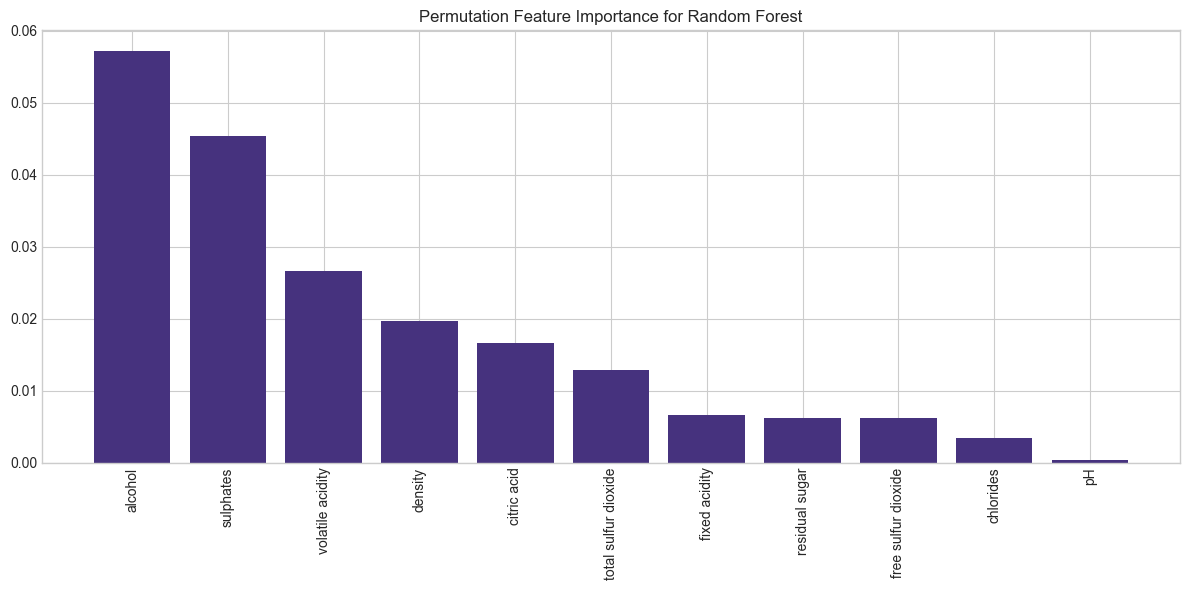


Top features by importance:
alcohol: 0.0572 ± 0.0073
sulphates: 0.0453 ± 0.0076
volatile acidity: 0.0266 ± 0.0045
density: 0.0197 ± 0.0056
citric acid: 0.0166 ± 0.0034
total sulfur dioxide: 0.0128 ± 0.0049
fixed acidity: 0.0066 ± 0.0033
residual sugar: 0.0063 ± 0.0028
free sulfur dioxide: 0.0063 ± 0.0031
chlorides: 0.0034 ± 0.0041
pH: 0.0003 ± 0.0033


In [21]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance for the best model
print("\nCalculating permutation feature importance...")
perm_importance = permutation_importance(tuned_model, X_test, y_test, 
                                         n_repeats=10, random_state=42)

# Sort features by importance
importance_indices = perm_importance.importances_mean.argsort()[::-1]

# Plot permutation feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(X_test.shape[1]), perm_importance.importances_mean[importance_indices])
plt.xticks(range(X_test.shape[1]), [X_test.columns[i] for i in importance_indices], rotation=90)
plt.title(f'Permutation Feature Importance for {best_model_name}')
plt.tight_layout()
plt.savefig(f'../reports/figures/permutation_importance_{best_model_name.replace(" ", "_").lower()}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\nTop features by importance:")
for i in importance_indices:
    print(f"{X_test.columns[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

## 7. Model Application Example
Let's demonstrate how to use our trained model for prediction with a few examples:


In [23]:
# Create sample data for prediction (examples from test set)
sample_indices = [0, 1, 2]  # First three samples from test set
sample_wines = X_test.iloc[sample_indices]
true_quality = y_test.iloc[sample_indices]

# Get the original (unscaled) values
scaler = processed_data['scaler']
sample_wines_original = pd.DataFrame(
    scaler.inverse_transform(sample_wines),
    columns=sample_wines.columns
)

# Make predictions
predictions = tuned_model.predict(sample_wines)
if hasattr(tuned_model, "predict_proba"):
    probabilities = tuned_model.predict_proba(sample_wines)[:, 1]
else:
    probabilities = None
    
# Display results
print("Sample Wine Predictions:")
for i, (pred, true) in enumerate(zip(predictions, true_quality)):
    print(f"\nSample {i+1}:")
    for feature, value in sample_wines_original.iloc[i].items():
        print(f"  {feature}: {value:.2f}")
    print(f"  Predicted Quality: {'Good' if pred == 1 else 'Not Good'}")
    print(f"  Actual Quality: {'Good' if true == 1 else 'Not Good'}")
    if probabilities is not None:
        print(f"  Probability of Good Quality: {probabilities[i]:.2f}")

# Calculate overall test set performance
test_accuracy = tuned_model.score(X_test, y_test)
y_pred = tuned_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)

print(f"\nOverall test set performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

    

Sample Wine Predictions:

Sample 1:
  fixed acidity: 10.40
  volatile acidity: 0.41
  citric acid: 0.55
  residual sugar: 3.20
  chlorides: 0.08
  free sulfur dioxide: 22.00
  total sulfur dioxide: 54.00
  density: 1.00
  pH: 3.15
  sulphates: 0.89
  alcohol: 9.90
  Predicted Quality: Not Good
  Actual Quality: Not Good
  Probability of Good Quality: 0.16

Sample 2:
  fixed acidity: 8.20
  volatile acidity: 0.57
  citric acid: 0.26
  residual sugar: 2.20
  chlorides: 0.06
  free sulfur dioxide: 28.00
  total sulfur dioxide: 65.00
  density: 1.00
  pH: 3.30
  sulphates: 0.43
  alcohol: 10.10
  Predicted Quality: Not Good
  Actual Quality: Not Good
  Probability of Good Quality: 0.08

Sample 3:
  fixed acidity: 6.80
  volatile acidity: 0.67
  citric acid: 0.00
  residual sugar: 1.90
  chlorides: 0.08
  free sulfur dioxide: 22.00
  total sulfur dioxide: 39.00
  density: 1.00
  pH: 3.40
  sulphates: 0.74
  alcohol: 9.70
  Predicted Quality: Not Good
  Actual Quality: Not Good
  Probability

## 8. Conclusion

In [26]:
print("\nConclusion:")
print(f"1. We've successfully built a wine quality prediction model using {best_model_name}.")
print(f"2. After hyperparameter tuning, the model achieved an F1 score of {tuned_results['f1_score']:.4f} on the test set.")
print("3. The most important features for predicting wine quality are:")
for i in importance_indices[:3]:
    print(f"   - {X_test.columns[i]}")
print("\n4. These findings align with wine chemistry, where alcohol content, acidity levels,")
print("   and preservatives like sulphates play crucial roles in wine quality.")
print("\n5. This model could help winemakers focus on the most influential factors")
print("   during production to improve wine quality.")


Conclusion:
1. We've successfully built a wine quality prediction model using Random Forest.
2. After hyperparameter tuning, the model achieved an F1 score of 0.7222 on the test set.
3. The most important features for predicting wine quality are:
   - alcohol
   - sulphates
   - volatile acidity

4. These findings align with wine chemistry, where alcohol content, acidity levels,
   and preservatives like sulphates play crucial roles in wine quality.

5. This model could help winemakers focus on the most influential factors
   during production to improve wine quality.
